In [1]:
import deimos
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import sys
import PeakDetective
import PeakDetective.detection_helper as detection_helper
import scipy.stats as stats
import seaborn as sb
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix
import sklearn.metrics as met
import random as rd
import importlib
import pickle as pkl
import NeatMS as ntms
from copy import deepcopy

def makePRCPlot(pred,true,noSkill=True,label=""):

    prec, recall, threshs = met.precision_recall_curve(true, pred)

    auc = np.round(met.auc(recall, prec), 4)

    plt.plot(recall, prec, label=label + " prAUC=" + str(auc))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    if noSkill:
        numPositive = len([x for x in true if x > 0.5])
        numNegative = len(true) - numPositive
        plt.plot([0, 1.0],
                 [numPositive / float(numPositive + numNegative), numPositive / float(numPositive + numNegative)],
                 label="NSL prAUC=" + str(
                     np.round(numPositive / float(numPositive + numNegative), 4)))
    plt.legend()
    return auc

def makeViolinPlot(pred,true):
    
    plt_dict = {}
    
    for p,t in zip(pred,true):
        if t > 0.5:
            group = "true peak"
        else:
            group = "artifact"
        plt_dict[len(plt_dict)] = {"group":group,"prediction":p}
        
    plt_dict = pd.DataFrame.from_dict(plt_dict,orient="index")
    
    sb.violinplot(data=plt_dict,x="group",y="prediction",cut=0)
    
def makeROCPlot(pred,true,label="",noSkill=True,color=None):

    fpr, tpr, threshs = met.roc_curve(true, pred)

    auc = np.round(met.auc(fpr, tpr), 4)

    if color is None: plt.plot(fpr, tpr, label=label + ": AUROC=" + str(auc))
    else: plt.plot(fpr, tpr, label=label + ": AUROC=" + str(auc),color=color)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    if noSkill:
        plt.plot([0, 1.0],[0,1.0],label="NSL",color="grey",linestyle="--")
    plt.legend()
    return auc

def plot_overlayedEIC(rawdatas,mz,rt_start,rt_end,resolution=60,smoothing=0,alpha=0.3,color="black"):
    ts = np.linspace(rt_start,rt_end,resolution)
    for data in rawdatas:
        s = data.interpolate_data(mz,rt_start,rt_end)
        ints  = [np.max([x,0]) for x in s(ts)]
        plt.plot(ts,ints,alpha=alpha)

In [2]:
#importlib.reload(PeakDetective)

In [3]:
resolution = 60
window = 1.0

align = True

In [4]:
#covid_plasma
datadir = "D:/PeakDetective/data/covid_plasma/"
ms1ppm = 25.5
peakWidth = (13.8,114.6)
s2n = 13.6
noise = 1
mzDiff = 0.0144
prefilter = 5
cutoff = 0.75 #default cutoff from last run

In [46]:
#ST000081
datadir = "D:/PeakDetective/data/ST000081/"
ms1ppm = 11.5
peakWidth = (8.5,31.3)
s2n = 6.81
noise = 1
mzDiff = 0.0144
prefilter = 5.4
cutoff = 0.6 #default cutoff from last run

In [79]:
#ST001882_GT_RP_Positive
datadir = "D:/PeakDetective/data/ST001882_GT_RP_Positive/"
ms1ppm = 11.5
peakWidth = (8.576,30)
s2n = 9.1
noise = 12970
mzDiff = 0.0144
prefilter = 1
cutoff = 0.5 #default cutoff from last run

In [2]:
#ST000992
datadir = "D:/PeakDetective/data/ST000992/"
ms1ppm = 45
peakWidth = (5,20)
s2n = 1.46
noise = 1
mzDiff = 0.0012
prefilter = 5.4
cutoff = 0.5 #default cutoff from last run

In [47]:
det = detection_helper.PeakList()
#det.runXCMS(datadir, "xcms_peak_list.csv", "negative", ms1ppm, peakWidth,s2n=s2n,noise=noise,mzDiff=mzDiff,prefilter=prefilter)
det.readXCMSPeakList(datadir+"xcms_peak_list.csv")
#det.to_skyline(datadir+"xcms_peak_list_transition_list.csv","Negative",moleculeListName = "XCMS peaks")
peakList = pd.DataFrame(det.peakList)
#peakList = peakList[["mz","rt"]]
peakList

,mz,rt,rt_start,rt_end,CSH_QC 02_neg_0314.mzML,CSH_QC 03_neg_0314.mzML,CSH_QC 04_neg_0314.mzML,CSH_QC 05_neg_0314.mzML,CSH_QC 06_neg_0314.mzML,CSH_QC01_neg_0314.mzML
FT0001,91.005820,9.560227,9.560227,9.560227,485.777941,0.000000,0.000000,0.000000,3110.835558,16744.833372
FT0002,100.935555,9.643209,9.643209,9.643209,0.000000,0.000000,0.000000,0.000000,0.000000,2916.834364
FT0003,102.958559,9.676374,9.676374,9.676374,0.000000,0.000000,0.000000,0.000000,0.000000,5683.065903
FT0004,104.023052,0.465233,0.465204,0.465253,10364.592212,20588.189441,21412.490127,18892.308099,7529.377449,12672.578047
FT0005,105.019255,0.465253,0.465233,0.473517,40604.911223,40533.364635,42035.413412,34037.576180,9155.274744,37203.250919
...,...,...,...,...,...,...,...,...,...,...
FT1830,1502.081893,5.672045,5.672045,5.672045,865.726513,1316.500685,846.628051,1171.188893,1373.243643,886.594990
FT1831,1502.149000,8.532183,8.532183,8.532183,6209.532937,1416.036881,397.042454,472.230287,836.116128,1482.583942
FT1832,1509.110701,5.638857,5.638857,5.638857,266.986125,497.067846,0.000000,158.431769,1196.585734,203.374788
FT1833,1510.115836,5.647000,5.647000,5.647000,349.866058,666.100117,441.358264,422.254199,566.142752,1040.143830


In [48]:
files = [x for x in os.listdir(datadir) if ".mzML" in x]
print(files)
raw_data = []
for file in files:
    temp = PeakDetective.rawData()
    temp.readRawDataFile(datadir + file,ms1ppm)
    raw_data.append(temp)
    

['CSH_QC 02_neg_0314.mzML', 'CSH_QC 03_neg_0314.mzML', 'CSH_QC 04_neg_0314.mzML', 'CSH_QC 05_neg_0314.mzML', 'CSH_QC 06_neg_0314.mzML', 'CSH_QC01_neg_0314.mzML']


In [49]:
integ = PeakDetective.PeakDetective(numCores = 15,resolution=resolution)

In [50]:
peakList_labeled = pd.read_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"),index_col=0)

In [51]:
if __name__ == "__main__":
    rts = peakList_labeled["rt"].values
    X_labeled_aligned = integ.makeDataMatrix(raw_data,peakList_labeled["mz"],peakList_labeled["rt"],align=True)
    X_labeled_unaligned = integ.makeDataMatrix(raw_data,peakList_labeled["mz"],peakList_labeled["rt"],align=False)


forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 


In [52]:
y_labeled = np.concatenate([peakList_labeled["classification"].values for _ in range(len(raw_data))])
y_labeled = np.array([[-1*y + 1,y] for y in y_labeled])

In [53]:
integ.load(datadir + "active/")

In [54]:
y_pred_aligned = integ.classifyMatrix(X_labeled_aligned)

94/94 [==============================] - 0s 2ms/step


In [55]:
y_pred_unligned = integ.classifyMatrix(X_labeled_unaligned)

94/94 [==============================] - 0s 2ms/step


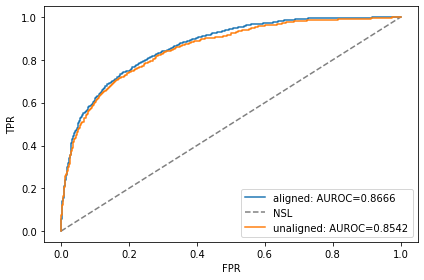

In [56]:
makeROCPlot(y_pred_aligned[:,1],y_labeled[:,1],noSkill=True,label="aligned")
makeROCPlot(y_pred_unligned[:,1],y_labeled[:,1],noSkill=False,label="unaligned")
plt.tight_layout()
plt.savefig(datadir+"ROC_alignment.png",dpi=300)

In [ ]:
if __name__ == "__main__":
    Xs = {}
    shifts = [0,0.025,0.05,0.075,0.1]
    for shift in shifts:
        Xs[shift] = integ.makeDataMatrix(raw_data[:1],peakList_labeled["mz"],peakList_labeled["rt"] + shift,align=False)


forming matrix |██████████████████████████████████████████████████| 100.0% 


In [ ]:
y = peakList_labeled["classification"].values
y = np.array([[-1*y + 1,y] for y in y])
shiftOrder = list(Xs.keys())
shiftOrder.sort(key=lambda x: abs(x))

for shift in shiftOrder[:-1]:
    y_pred = integ.classifyMatrix(Xs[shift])
    makeROCPlot(y_pred[:,1],y[:,1],noSkill=False,label="shift=" + str(shift))
    
shift = shiftOrder[-1]
y_pred = integ.classifyMatrix(Xs[shift])
makeROCPlot(y_pred[:,1],y[:,1],noSkill=True,label="shift=" + str(shift))

plt.tight_layout()
plt.savefig(datadir+"ROC_shift.png",dpi=300)